# HW_8

In [99]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [100]:
num_classes = 10 
num_features = 784 
learning_rate = 0.0001  
training_steps = 5000  
batch_size = 256 
display_step = 100 

n_hidden_1 = 512  
n_hidden_2 = 1024 

In [101]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [102]:
# Створення нейронної мережі з Dropout
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=0)

    return x

In [103]:
# Функція помилки
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [104]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.Adam(learning_rate)  

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [105]:
# Тренування мережі
loss_history = [] 
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        
        loss_history.append(loss)
        accuracy_history.append(acc)
        
        print("Шаг: %i, Поточна втрата: %f, Точність: %f" % (step, loss, acc))

Шаг: 100, Поточна втрата: 174.674713, Точність: 0.140625
Шаг: 200, Поточна втрата: 170.852661, Точність: 0.175781
Шаг: 300, Поточна втрата: 167.003555, Точність: 0.171875
Шаг: 400, Поточна втрата: 165.376877, Точність: 0.136719
Шаг: 500, Поточна втрата: 160.261078, Точність: 0.218750
Шаг: 600, Поточна втрата: 157.619263, Точність: 0.246094
Шаг: 700, Поточна втрата: 153.956161, Точність: 0.312500
Шаг: 800, Поточна втрата: 150.650452, Точність: 0.351562
Шаг: 900, Поточна втрата: 146.814468, Точність: 0.398438
Шаг: 1000, Поточна втрата: 144.700867, Точність: 0.367188
Шаг: 1100, Поточна втрата: 140.817749, Точність: 0.394531
Шаг: 1200, Поточна втрата: 137.909882, Точність: 0.417969
Шаг: 1300, Поточна втрата: 134.352097, Точність: 0.453125
Шаг: 1400, Поточна втрата: 132.001389, Точність: 0.429688
Шаг: 1500, Поточна втрата: 128.576828, Точність: 0.500000
Шаг: 1600, Поточна втрата: 125.351379, Точність: 0.527344
Шаг: 1700, Поточна втрата: 123.931244, Точність: 0.492188
Шаг: 1800, Поточна втра

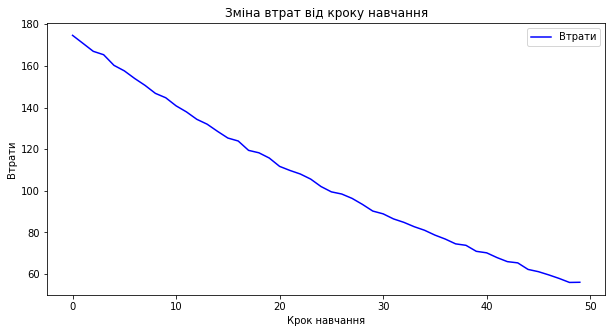

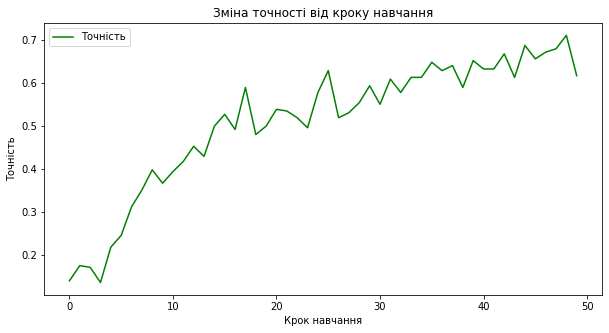

In [106]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведення графіків
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрати', color='blue')
plt.title('Зміна втрат від кроку навчання')
plt.xlabel('Крок навчання')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='green')
plt.title('Зміна точності від кроку навчання')
plt.xlabel('Крок навчання')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [107]:
# Обчислення точності та втрат на тестових даних
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print("Точність на тестових даних: {:.4f}".format(test_accuracy))

test_loss = cross_entropy(test_pred, y_test)
print("Втрати на тестових даних: {:.4f}".format(test_loss))

Точність на тестових даних: 0.6749
Втрати на тестових даних: 2157.2083


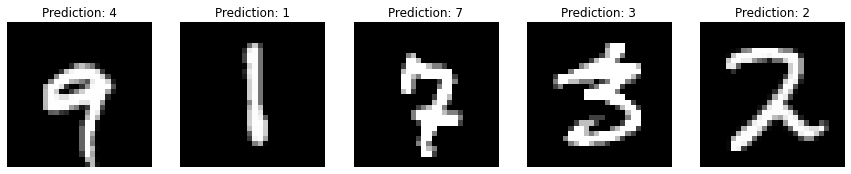

In [108]:
# Тестування навченої мережі на декількох зображеннях
num_images_to_test = 5
random_indices = np.random.choice(x_test.shape[0], num_images_to_test, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]
predictions = neural_net(images_to_test)

plt.figure(figsize=(15, 5))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i+1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title('Prediction: {}'.format(np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

In [109]:
'''Висновки:

1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, 
оскільки більшість передбачень вірно збігаються з фактичними мітками. 
Однак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.

2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. 
Наприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.
'''

'Висновки:\n\n1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, \nоскільки більшість передбачень вірно збігаються з фактичними мітками. \nОднак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.\n\n2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. \nНаприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.\n'